This notebooks produces some plots associated with the paper produced with this repository. It creates the plots of the optimizations:
1. That don't include the network metrics
2. That include the network metrics (named as alpha screening in here).

---
Author: Jordi Grau Escolano


# 1. Load data

In [1]:
import os, sys, warnings
from pathlib import Path as PathLib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize,ListedColormap
from matplotlib import MatplotlibDeprecationWarning
import seaborn as sns
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

# Add project root to path
project_root = PathLib().resolve().parents[0]
sys.path.insert(0, str(project_root))

from paths import *
import src.data_loader as dl
import src.optimization.experiments.helper_experiment as he
import src.optimization.helper_optimization as ho
import src.results_exploration.helper_visualizations as hv
import src.optimization.experiments.graph_metrics.alpha_screening.alpha_screening_plot as asp

ROOT = "../"

# Load data
df, G, distance_matrix, id_to_idx, idx_to_id, _, STATION_MIN_DISTANCE = he.load_data(root=ROOT)
city_boundary = dl.load_bcn_boundary()

# Define scenarios
weights_dict = {
    "s1": {"population": 0.4, "pois_total": 0.35, "pois_entropy": 0.25},
    "s2": {"bus_lines": 0.2, "metro_lines": 0.2, "tram_lines": 0.1, "pois_total": 0.4, "bike_lane_kms": 0.1},
    "s3": {"income_2022_pers": 0.4, "unemployment": 0.3, "education_primary": 0.3}
}

# Check scenario weights sum to 1
for s in weights_dict:
    print(f"scenario={s} -> {sum(weights_dict[s].values())}")

# Compute normalized scores
df_weights = pd.DataFrame()
for s in weights_dict:
    if df_weights.empty:
        df_weights = ho.sum_and_normalize_all_node_scores(df, weights_dict[s])
        df_weights.rename(columns={'norm_score': s}, inplace=True)
    else:
        df_weights[s] = ho.sum_and_normalize_all_node_scores(df, weights_dict[s])['norm_score']

df_weights.head(2)

	Successfully loaded graph bike_graph with protocol 5
Loading existing node attributes from ..//data/processed/nodes/node_attributes.csv
Loading pre-computed distance matrix and mappings...
	Successfully loaded mappings with protocol 5
Successfully loaded distance matrix of shape (18721, 18721)
scenario=s1 -> 1.0
scenario=s2 -> 1.0
scenario=s3 -> 1.0


income_2022_pers  household_avg_m2  altitude  has_bike_lane  \
node_id                                                                   
21638831                0.64              0.68      2.09              0   
1259351831              0.66              0.71      2.68              0   

            bike_lane_kms  n_health_care  n_culture  n_tourism  n_recreation  \
node_id                                                                        
21638831              0.0            0.0       0.14       0.22          0.12   
1259351831            0.0            0.0       0.00       0.00          0.00   

            n_sport  ...  motos_abs  cars_abs  others_abs  \
node_id              ...                                    
21638831        0.0  ...        0.0       0.0        3.22   
1259351831      0.0  ...        0.0       0.0        0.00   

            non_spanish_population  unemployment_percentage  \
node_id                                                       
21638831                      0.04                     0.67   
1259351831                    0.00                     0.68   

                                  geometry   score        s1        s2  \
node_id                                                                  
21638831    POINT (431665.633 4579427.183)  0.1925  0.240175  0.147952   
1259351831   POINT (431577.21 4579241.901)  0.0790  0.098565  0.100396   

                  s3  
node_id               
21638831    0.277778  
1259351831  0.256667  

[2 rows x 48 columns]

# 1. Plot scenario scores

In [2]:
def plot_scenario(df_weights, columns, weights_dict, city_boundary, rows, cols, figsize):
    """
    Plots the scenario on a map.

    Args:
        df_weights (pd.DataFrame): The dataframe containing the weights.
        columns (list): The columns to plot.
        weights_dict (dict): The weights to plot.
    """
    cmap = plt.get_cmap('viridis_r')
    norm = Normalize(vmin=0, vmax=1)

    str_replace = {
        'pois_count': 'pois_total',
    }

    if rows == 1:
        gridspec_kw = {'wspace': 0.05}
    else:
        gridspec_kw = {'wspace': 0.05, 'hspace': 0.1}
    fig, axs = plt.subplots(rows, cols, figsize=figsize, gridspec_kw=gridspec_kw)
    axs = np.array(axs).flatten()

    for i, column in enumerate(columns):
        hv.plot_nodes_on_map(df_weights, column, axs[i], city_boundary, show_colorbar=False, show_norm_raw_vals=False)
        
        # Add black border around first subplot
        if columns != ['s1', 's2', 's3']:
            if i == 0:
                axs[i].set_axis_on()
                axs[i].spines['top'].set_linewidth(2)
                axs[i].spines['bottom'].set_linewidth(2)
                axs[i].spines['left'].set_linewidth(2)
                axs[i].spines['right'].set_linewidth(2)
            # Hide the rest of the axes
            for ax in axs[1:]:
                ax.set_axis_off()
        else:
            axs[i].set_axis_off()
            

    # Set titles
    str_replace = {
                's1': 'S1',
                's2': 'S2',
                's3': 'S3',
            }
    for i, column in enumerate(columns):
        if column not in ['s1', 's2', 's3']:
            axs[i].set_title(f'{column} ({weights_dict[columns[0]][column]})', fontsize=9)
        else:
            axs[i].set_title(str_replace[column], fontsize=9)

    # Add colorbar to the right of the figure
    cax = fig.add_axes(rect=(0.92, 0.2, 0.01, 0.6))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array(df_weights['pois_entropy'])
    cbar = plt.colorbar(sm, cax=cax, pad=0.05)
    cbar.set_label('Normalized Score')

    

    # Hide x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

    return fig


In [3]:
# Results directory
RESULT_DIR = f'{ROOT}/{VISUALIZATIONS}/scenarios/no_graph_metrics'
os.makedirs(RESULT_DIR, exist_ok=True)

# All scenarios
if not os.path.exists(f'{RESULT_DIR}/all_scenarios.png'):
    fig = plot_scenario(df_weights, ['s1', 's2', 's3'], weights_dict, city_boundary, 1, 3, (9, 5))
    fig.savefig(f'{RESULT_DIR}/all_scenarios.png', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()
    plt.close()

# Scenario 1
if not os.path.exists(f'{RESULT_DIR}/scenario_1.png'):
    fig = plot_scenario(df_weights, ['s1', 'population', 'pois_total', 'pois_entropy'], weights_dict, city_boundary, 1, 4, (12, 5))
    fig.savefig(f'{RESULT_DIR}/scenario_1.png', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()
    plt.close()

# Scenario 2
if not os.path.exists(f'{RESULT_DIR}/scenario_2.png'):
    fig = plot_scenario(df_weights, ['s2', 'bus_lines', 'metro_lines', 'tram_lines', 'pois_total', 'bike_lane_kms'], weights_dict, city_boundary, 2, 3, (9, 8))
    fig.savefig(f'{RESULT_DIR}/scenario_2.png', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()
    plt.close()

# Scenario 3
if not os.path.exists(f'{RESULT_DIR}/scenario_3.png'):
    fig = plot_scenario(df_weights, ['s3', 'income_2022_pers', 'unemployment', 'education_primary'], weights_dict, city_boundary, 1, 4, (12, 5))
    fig.savefig(f'{RESULT_DIR}/scenario_3.png', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()
    plt.close()

# 2. BSS utility WITHOUT graph metrics

In [4]:
# Load optimization results
results_file = '/home/data/processed/experiments/scenarios/no_graph_metrics.csv'
df_results = pd.read_csv(results_file)
df_results['best_solution'] = df_results['best_solution'].apply(lambda x: eval(x))
df_results['weights'] = df_results['weights'].apply(lambda x: {k.split(': ')[0]: float(k.split(': ')[1]) for k in eval(x)})

# Stations for each scenario
results_dict = {
    'stations': {s: df_results[df_results['weights'] == w]['best_solution'].values[0] 
                if len(df_results[df_results['weights'] == w]) > 0 else []
                for s,w in weights_dict.items()},
    'weights': weights_dict
}

# Get data for one scenario
def get_data_for_one_scenario(scenario, df_weights=df_weights, results_dict=results_dict):
    weights = results_dict['weights'][scenario]
    stations = results_dict['stations'][scenario]
    df_data = df_weights[df_weights.index.isin(stations)]
    return weights, stations, df_data


# Variables to plot and their string replacements
vars = ["population", "pois_total", "pois_entropy", 
        "bus_lines", "metro_lines", "tram_lines", 
        "income_2022_pers", "unemployment", "education_primary", "bike_lane_kms"]

N = len(vars)

string_replace = {
    'population': 'pop',
    'pois_total': 'pois_count',
    'pois_entropy': 'pois_div',
    'bus_lines': 'bus',
    'bike_lane_kms': 'lanes',
    'metro_lines': 'metro',
    'tram_lines': 'tram',
    'income_2022_pers': 'income',
    'unemployment': 'unemp',
    'education_primary': 'edu',
}

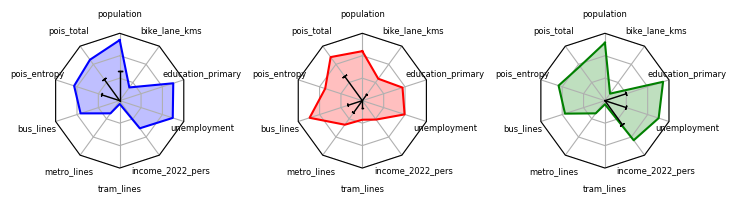

In [5]:
theta = hv.radar_factory(N, frame='polygon', font_size=6)
scenarios_plot = [(f's{i}', get_data_for_one_scenario(f's{i}')[2][vars].mean()) for i in range(1,4)]

fig, axs = plt.subplots(figsize=(8, 4), nrows=1, ncols=3, 
                        subplot_kw=dict(projection='radar'),
                        gridspec_kw=dict(wspace=0.8, hspace=0.5, top=0.85, bottom=0.05))

for ax, (title, means), color in zip(axs, scenarios_plot, ['b', 'r', 'g']):
    values = means.values
    ax.plot(theta, values, color=color)
    ax.fill(theta, values, facecolor=color, alpha=0.25)
    
    for i, angle in enumerate(theta):
        if (var := vars[i]) in weights_dict[title]:
            weight = weights_dict[title][var]
            ax.plot([angle, angle], [0, weight], 'k-', linewidth=1)
            ax.plot([angle-0.07, angle+0.07], [weight, weight], 'k-', linewidth=1)
            
    ax.set_varlabels(vars)
    ax.set_rgrids([0, 0.3, 0.6, 0.9])

plt.show()

In [6]:
def add_radar_chart(ax, mean_values, std_values, labels, weights, string_replace, color='tab:blue'):
    # Add white background rectangle to the inset axes
    rect = plt.Rectangle((0, 0), 0.45, 0.35, 
                        transform=ax.transAxes, 
                        facecolor='white', alpha=0.7, zorder=2)
    ax.add_patch(rect)

    ax_inset = ax.inset_axes(bounds=[0.09, 0.05, 0.25, 0.25], projection='radar')
    hv.plot_radar_chart(
        mean_values=mean_values, std_values=std_values,
        labels=labels, weights=weights,
        ax=ax_inset, title=None, color=color, font_size=7,
        string_replace=string_replace)
    return ax 

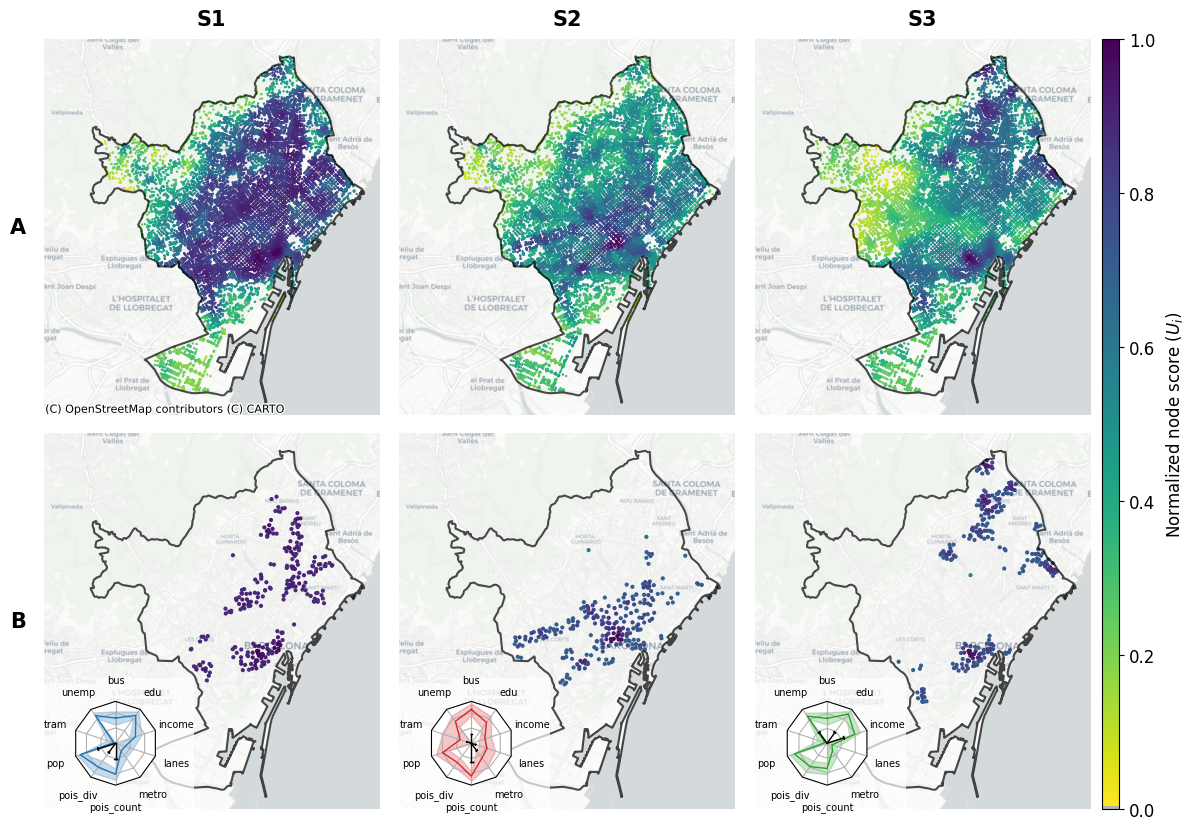

In [7]:
# Create figure with extra space on right for colorbar
title_size = 15
colorbar_font_size = 12

# Get data for all scenarios once
scenario_data = {
    's1': get_data_for_one_scenario('s1')[2],
    's2': get_data_for_one_scenario('s2')[2], 
    's3': get_data_for_one_scenario('s3')[2]
}

# Setup figure and grid
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.01, hspace=0.05)

# Create main axes
axs = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(3)]
axs = np.array(axs)

# Add column and row titles
for i, label in enumerate(['S1', 'S2', 'S3']):
    axs[i].set_title(label, pad=10, fontsize=title_size, fontweight='bold')
for i, label in enumerate(['A', 'B']):
    axs[i*3].text(-0.1, 0.5, label, transform=axs[i*3].transAxes, 
                  fontsize=title_size, fontweight='bold', va='center')

# Plot maps
for i, scenario in enumerate(['s1', 's2', 's3']):
    # Top row - weights
    hv.plot_nodes_on_map(df_weights, scenario, axs[i], city_boundary, 
                        show_colorbar=False, show_norm_raw_vals=False,
                        attribution=(i==0))
    
    # Bottom row - scenario data
    hv.plot_nodes_on_map(scenario_data[scenario], scenario, axs[i+3], city_boundary,
                        node_size=4, show_colorbar=False, show_norm_raw_vals=False)
    
    # Add radar charts to bottom row
    add_radar_chart(axs[i+3], 
                   scenario_data[scenario][vars].mean(),
                   scenario_data[scenario][vars].std(), 
                   vars, weights_dict[scenario], string_replace,
                   color=['tab:blue', 'tab:red', 'tab:green'][i])

# Set map bounds to leave space for the radar charts
for ax in axs:
    ax.set_xlim(420000, 436200)
    ax.set_ylim(4573700, 4591863)

# Custom colormap and colorbar
cax = fig.add_subplot(gs[:,3])
plt.colorbar(
    ScalarMappable(
        Normalize(0, 1), # normalize the colorbar to 0-1
        ListedColormap([(0.7,0.7,0.7,1)] + list(plt.get_cmap('viridis_r')(np.linspace(0,1,255)))) # gray + viridis_r
    ), 
    cax=cax
).set_label('Normalized node score ($U_i$)', fontsize=colorbar_font_size)
cax.tick_params(labelsize=colorbar_font_size)
cax.yaxis.set_label_coords(3.5, 0.5)

# Save and display
fig.savefig(f'{RESULT_DIR}/BSS_all_scenarios.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [8]:
# Getting the mean and std of each variable across all scenarios
for s in scenario_data:
    print(s)
    print("\tpopulation", round(scenario_data[s]['population'].mean(), 2), "±", round(scenario_data[s]['population'].std(), 2))
    print("\tpois_total", round(scenario_data[s]['pois_total'].mean(), 2), "±", round(scenario_data[s]['pois_total'].std(), 2))
    print("\tpois_entropy", round(scenario_data[s]['pois_entropy'].mean(), 2), "±", round(scenario_data[s]['pois_entropy'].std(), 2))
    print("\tbike_lane_kms", round(scenario_data[s]['bike_lane_kms'].mean(), 2), "±", round(scenario_data[s]['bike_lane_kms'].std(), 2))
    print("\tbus_lines", round(scenario_data[s]['bus_lines'].mean(), 2), "±", round(scenario_data[s]['bus_lines'].std(), 2))
    print("\tmetro_lines", round(scenario_data[s]['metro_lines'].mean(), 2), "±", round(scenario_data[s]['metro_lines'].std(), 2))
    print("\ttram_lines", round(scenario_data[s]['tram_lines'].mean(), 2), "±", round(scenario_data[s]['tram_lines'].std(), 2))
    print("\tincome_2022_pers", round(scenario_data[s]['income_2022_pers'].mean(), 2), "±", round(scenario_data[s]['income_2022_pers'].std(), 2))
    print("\tunemployment", round(scenario_data[s]['unemployment'].mean(), 2), "±", round(scenario_data[s]['unemployment'].std(), 2))
    print("\teducation_primary", round(scenario_data[s]['education_primary'].mean(), 2), "±", round(scenario_data[s]['education_primary'].std(), 2))


s1
	population 0.81 ± 0.06
	pois_total 0.68 ± 0.12
	pois_entropy 0.64 ± 0.16
	bike_lane_kms 0.22 ± 0.17
	bus_lines 0.55 ± 0.15
	metro_lines 0.21 ± 0.18
	tram_lines 0.04 ± 0.16
	income_2022_pers 0.46 ± 0.14
	unemployment 0.74 ± 0.08
	education_primary 0.75 ± 0.1
s2
	population 0.66 ± 0.15
	pois_total 0.72 ± 0.1
	pois_entropy 0.52 ± 0.11
	bike_lane_kms 0.36 ± 0.19
	bus_lines 0.74 ± 0.13
	metro_lines 0.4 ± 0.21
	tram_lines 0.25 ± 0.41
	income_2022_pers 0.31 ± 0.14
	unemployment 0.59 ± 0.15
	education_primary 0.56 ± 0.16
s3
	population 0.77 ± 0.1
	pois_total 0.57 ± 0.13
	pois_entropy 0.65 ± 0.15
	bike_lane_kms 0.12 ± 0.12
	bus_lines 0.56 ± 0.14
	metro_lines 0.21 ± 0.16
	tram_lines 0.05 ± 0.17
	income_2022_pers 0.65 ± 0.13
	unemployment 0.75 ± 0.09
	education_primary 0.82 ± 0.08


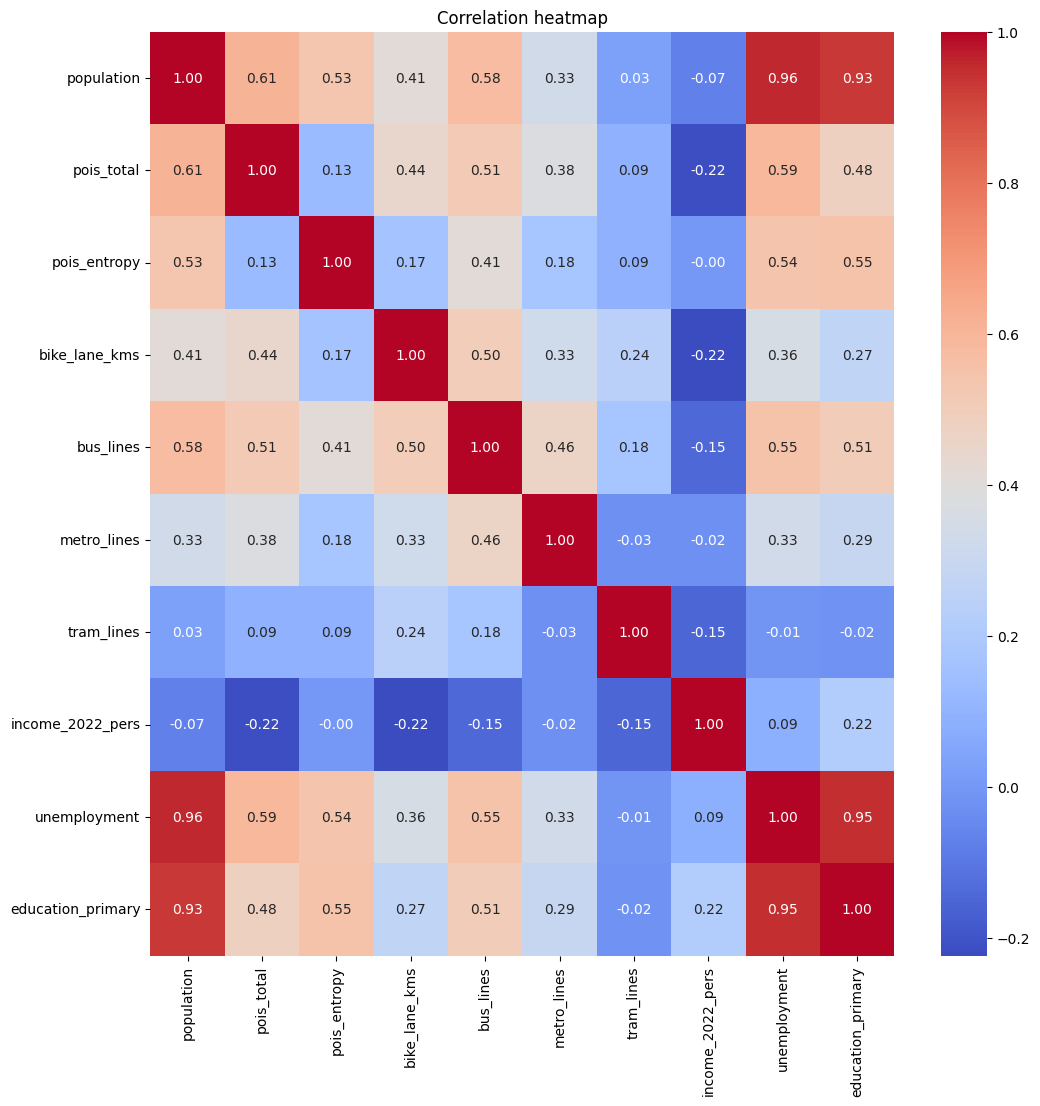

In [9]:
# Get correlations between variables across all scenarios
corr = df_weights.drop(columns=['geometry'])[[
    'population', 'pois_total', 'pois_entropy', 'bike_lane_kms', 'bus_lines', 'metro_lines', 'tram_lines', 'income_2022_pers', 'unemployment', 'education_primary']].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title(f"Correlation heatmap")
plt.show()

# 3. BSS utility WITH graph metrics (alpha screening)

In [10]:
RESULTS_DIR = f'{ROOT}/{VISUALIZATIONS}/scenarios/alpha_screening'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Load optimization results
df_results = f'{ROOT}/{PR_EXP}/scenarios/alpha_screening.csv'
df_results = pd.read_csv(df_results)
df_results['best_solution'] = df_results['best_solution'].apply(lambda x: eval(x))
df_results['weights'] = df_results['weights'].apply(lambda x: {k.split(': ')[0]: float(k.split(': ')[1]) for k in eval(x)})
df_results.drop([
    'experiment_idx', 'N_stations', 'minutes_to_complete', 'generations',
    'score_combination', 'penalty_power'], axis=1, inplace=True)

# Fill NaN values with scenario names
for scenario in ['s1', 's2', 's3']:
    df_results.loc[(df_results['alpha'].isna())
                   & (df_results['weights'] == weights_dict[scenario]), 'alpha'] = scenario.upper()

# Initialize dictionaries to store results for each scenario
alpha_scenarios = {scenario: {} for scenario in ['s1', 's2', 's3']}

# Process each scenario
for scenario in ['s1', 's2', 's3']:
    # Filter for specific scenario weights
    scenario_results = df_results[df_results['weights'] == weights_dict[scenario]].copy()
    # Sort results by alpha and calculate scenario values
    sorted_alphas = sorted(scenario_results['alpha'].astype(str).unique())
    for alpha in sorted_alphas:
        # Get stations for this alpha
        stations = scenario_results.loc[scenario_results['alpha'].astype(str) == alpha, 'best_solution'].iloc[0]
        
        # Calculate scenario values for these stations
        scenario_utility_vals = df_weights.loc[stations, scenario]
        scenario_input_vals = df_weights.loc[stations, vars]
        alpha_scenarios[scenario][alpha] = {
            'utility_vals': np.asarray(scenario_utility_vals),
            'means': {var: np.asarray(scenario_input_vals[var].mean()) for var in vars},
            'stds': {var: np.asarray(scenario_input_vals[var].std()) for var in vars},
            'all_values': {var: scenario_input_vals[var].values for var in vars}
        }
        
        # Print summary
        print(f"{scenario} α={alpha} → total {scenario} = {scenario_utility_vals.sum():.3f}")


s1 α=0.0 → total s1 = 215.711
s1 α=0.25 → total s1 = 219.648
s1 α=0.5 → total s1 = 219.989
s1 α=0.75 → total s1 = 222.255
s1 α=1.0 → total s1 = 223.764
s1 α=S1 → total s1 = 224.641
s2 α=0.0 → total s2 = 182.359
s2 α=0.25 → total s2 = 185.243
s2 α=0.5 → total s2 = 187.881
s2 α=0.75 → total s2 = 187.435
s2 α=1.0 → total s2 = 190.312
s2 α=S2 → total s2 = 190.501
s3 α=0.0 → total s3 = 181.427
s3 α=0.25 → total s3 = 186.096
s3 α=0.5 → total s3 = 188.613
s3 α=0.75 → total s3 = 189.343
s3 α=1.0 → total s3 = 189.982
s3 α=S3 → total s3 = 194.387


/tmp/ipykernel_32052/3166527649.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'S1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_results.loc[(df_results['alpha'].isna())


## 3.1. BSS utility distribution and nodes propierties

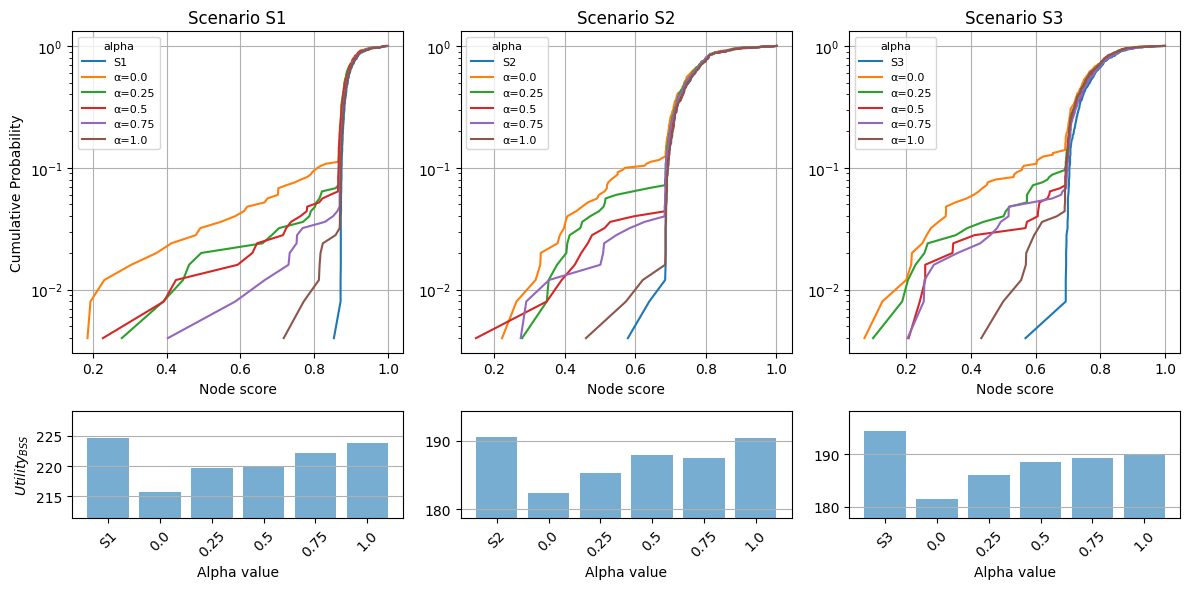

In [11]:
# Create figure with 3 columns for scenarios
fig, axes = plt.subplots(2, 3, figsize=(12,6), 
                        gridspec_kw={'height_ratios':[3,1]})

for col, scenario in enumerate(['s1', 's2', 's3']):
    ecdfs = {}
    totals = {}
    # Sort so 'No graph metrics' comes first, then sort remaining alphas numerically
    sorted_items = sorted(alpha_scenarios[scenario].items(), 
                        key=lambda x: (x[0] != scenario.upper(), x[0]))
    
    for alpha, data in sorted_items:
        x = np.sort(data['utility_vals'])
        y = np.arange(1, len(x)+1) / len(x)
        label = scenario.upper() if alpha == scenario.upper() else alpha
        ecdfs[label] = (x, y)
        totals[label] = data['utility_vals'].sum()

    # — ECDF panel —
    ax_ecdf = axes[0,col]
    for alpha, (x,y) in ecdfs.items():
        label = f'α={alpha}' if alpha != scenario.upper() else alpha
        ax_ecdf.plot(x, y, linestyle='-', marker='', label=label)
    ax_ecdf.set_ylabel('Cumulative Probability' if col == 0 else '')
    ax_ecdf.set_xlabel('Node score')
    ax_ecdf.grid(True)
    ax_ecdf.legend(title='alpha', title_fontsize=8, fontsize=8)
    ax_ecdf.set_yscale('log')
    ax_ecdf.set_title(f'Scenario {scenario.upper()}')

    # — Bar panel —
    ax_bar = axes[1,col]
    alphas = list(totals.keys())
    sums = list(totals.values())

    ax_bar.bar(range(len(alphas)), sums, alpha=0.6)
    ax_bar.set_xticks(range(len(alphas)))
    ax_bar.set_xticklabels(alphas, rotation=45)
    ax_bar.set_ylabel('$Utility_{BSS}$' if col == 0 else '')
    ax_bar.set_ylim(min(sums)*0.98, max(sums)*1.02)
    ax_bar.grid(True, axis='y')
    ax_bar.set_xlabel('Alpha value')

plt.tight_layout()
plt.show()

In [12]:
def plot_node_scores_plot(ax, alpha_order, alpha_scenarios, scenario, labelsize=8):
    """Simplified: Plot violin and bar plots for node scores and utility."""

    # Prepare data
    items = sorted(alpha_scenarios[scenario].items(), key=lambda x: (x[0] != scenario.upper(), x[0]))
    labels = [scenario.upper() if alpha == scenario.upper() else f"α={alpha}" for alpha, _ in items]
    scores = [data['utility_vals'] for _, data in items]
    totals = [np.sum(vals) for vals in scores]

    # Data
    violin_df = pd.DataFrame({'Alpha': np.repeat(labels, [len(v) for v in scores]),
                              'score': np.concatenate(scores)})
    bar_df = pd.DataFrame({'Alpha': labels, 'Total': totals})

    # Plot
    ax_twin = ax.twinx()
    sns.violinplot(data=violin_df, x='Alpha', y='score', ax=ax, color='tab:blue', cut=0)
    sns.barplot(data=bar_df, x='Alpha', y='Total', ax=ax_twin, alpha=0.4, color='grey', width=0.7)

    # Y-limits and ticks for violin
    vmin, vmax = violin_df['score'].min(), violin_df['score'].max()
    bottom, top = np.floor(vmin*10)/10, np.ceil(vmax*10)/10
    if bottom == top:
        bottom, top = np.floor((vmin-0.05)*10)/10, np.ceil((vmax+0.05)*10)/10
    ax.set_ylim(bottom, top)
    ax.set_yticks(np.linspace(bottom, top, 6))

    # Y-limits and ticks for bar
    bar_min, bar_max = int(np.floor(bar_df['Total'].min())), int(np.ceil(bar_df['Total'].max()))
    if bar_min == bar_max:
        bar_min, bar_max = bar_min-1, bar_max+1
    ax_twin.set_ylim(bar_min, bar_max)
    ticks = np.linspace(bar_min, bar_max, min(bar_max-bar_min+1, 6), dtype=int) if bar_max > bar_min else [bar_min]
    ax_twin.set_yticks(ticks)

    # Labels and formatting
    ax.set_ylabel('Normalized node score ($U_i$)', color='tab:blue', fontsize=labelsize)
    ax_twin.set_ylabel('$Utility_{BSS}$', color='grey', fontsize=labelsize)
    ax.tick_params(axis='y', labelcolor='tab:blue', labelsize=labelsize)
    ax_twin.tick_params(axis='y', labelcolor='grey', labelsize=labelsize)
    ax.grid(True, alpha=0.3)
    for axis in [ax, ax_twin]:
        # Replace 'α=0.0', 'α=1.0', and any of 'S1', 'S2', 'S3' with 'α=0', 'α=1', and 'Baseline' in xticklabels
        xticklabels = [
            lbl.get_text()
            .replace('α=0.0', 'α=0')
            .replace('α=1.0', 'α=1')
            .replace('S1', 'Baseline')
            .replace('S2', 'Baseline')
            .replace('S3', 'Baseline')
            for lbl in axis.get_xticklabels()
        ]
        axis.set_xticklabels(xticklabels, fontsize=labelsize)
        axis.set_xlabel('')


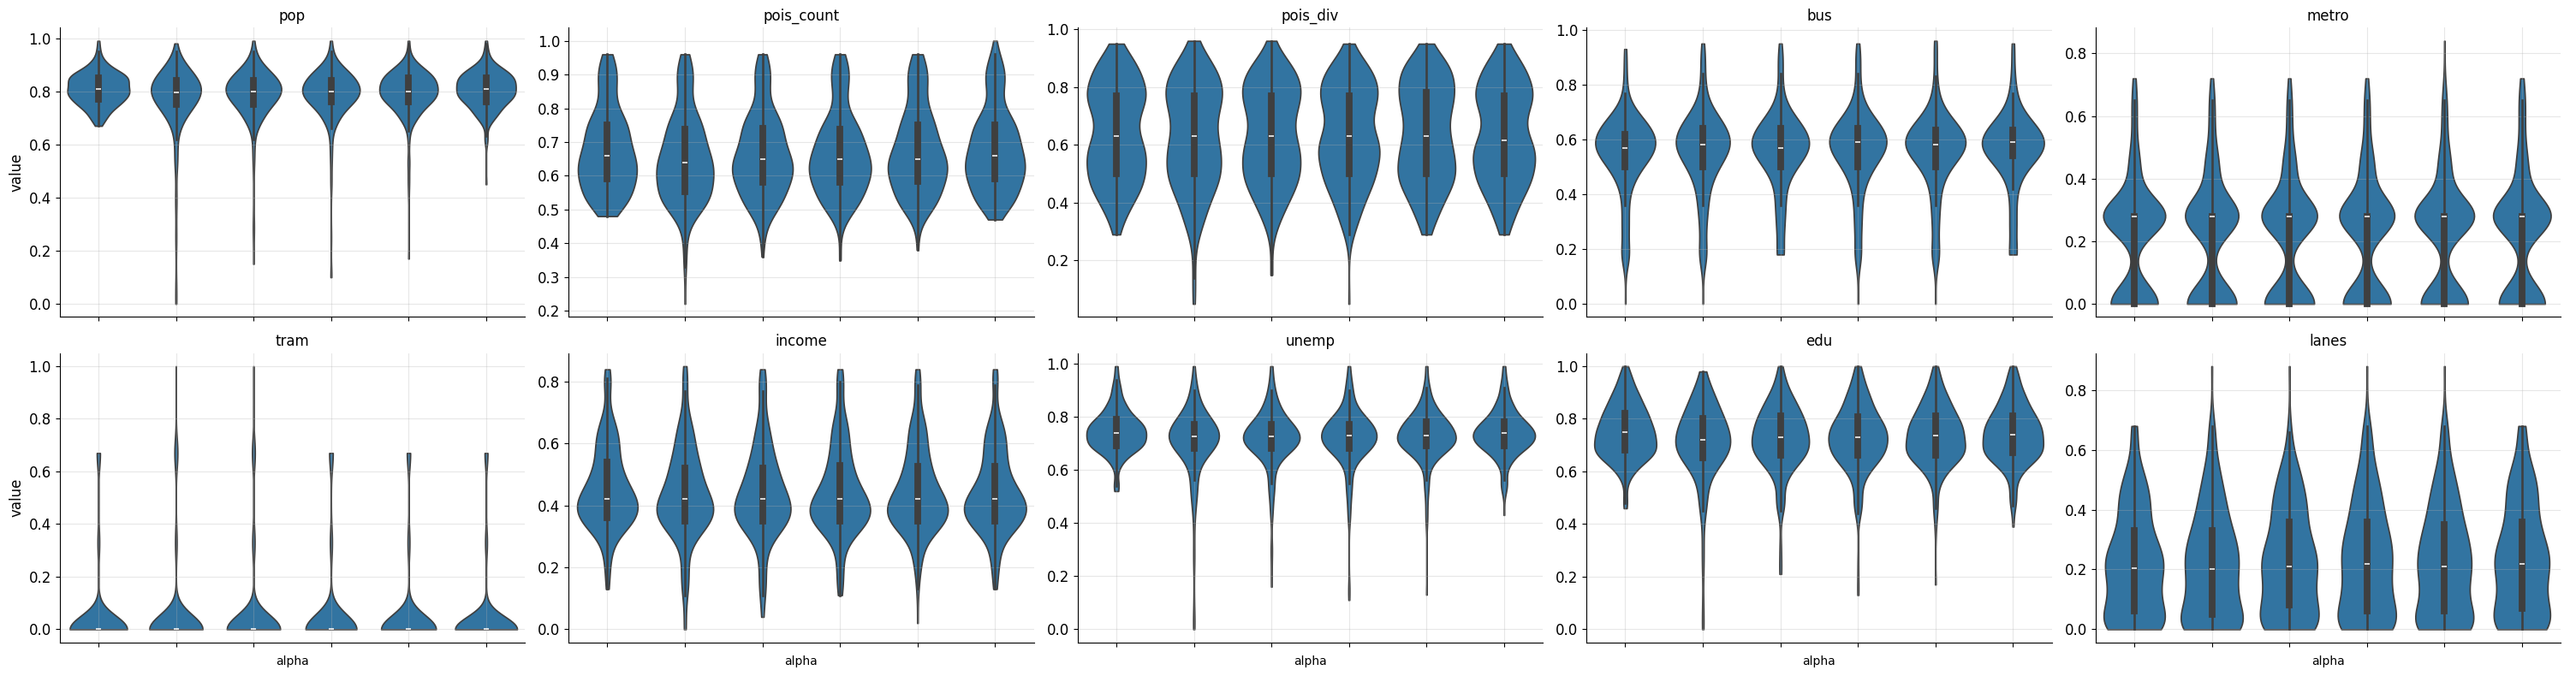

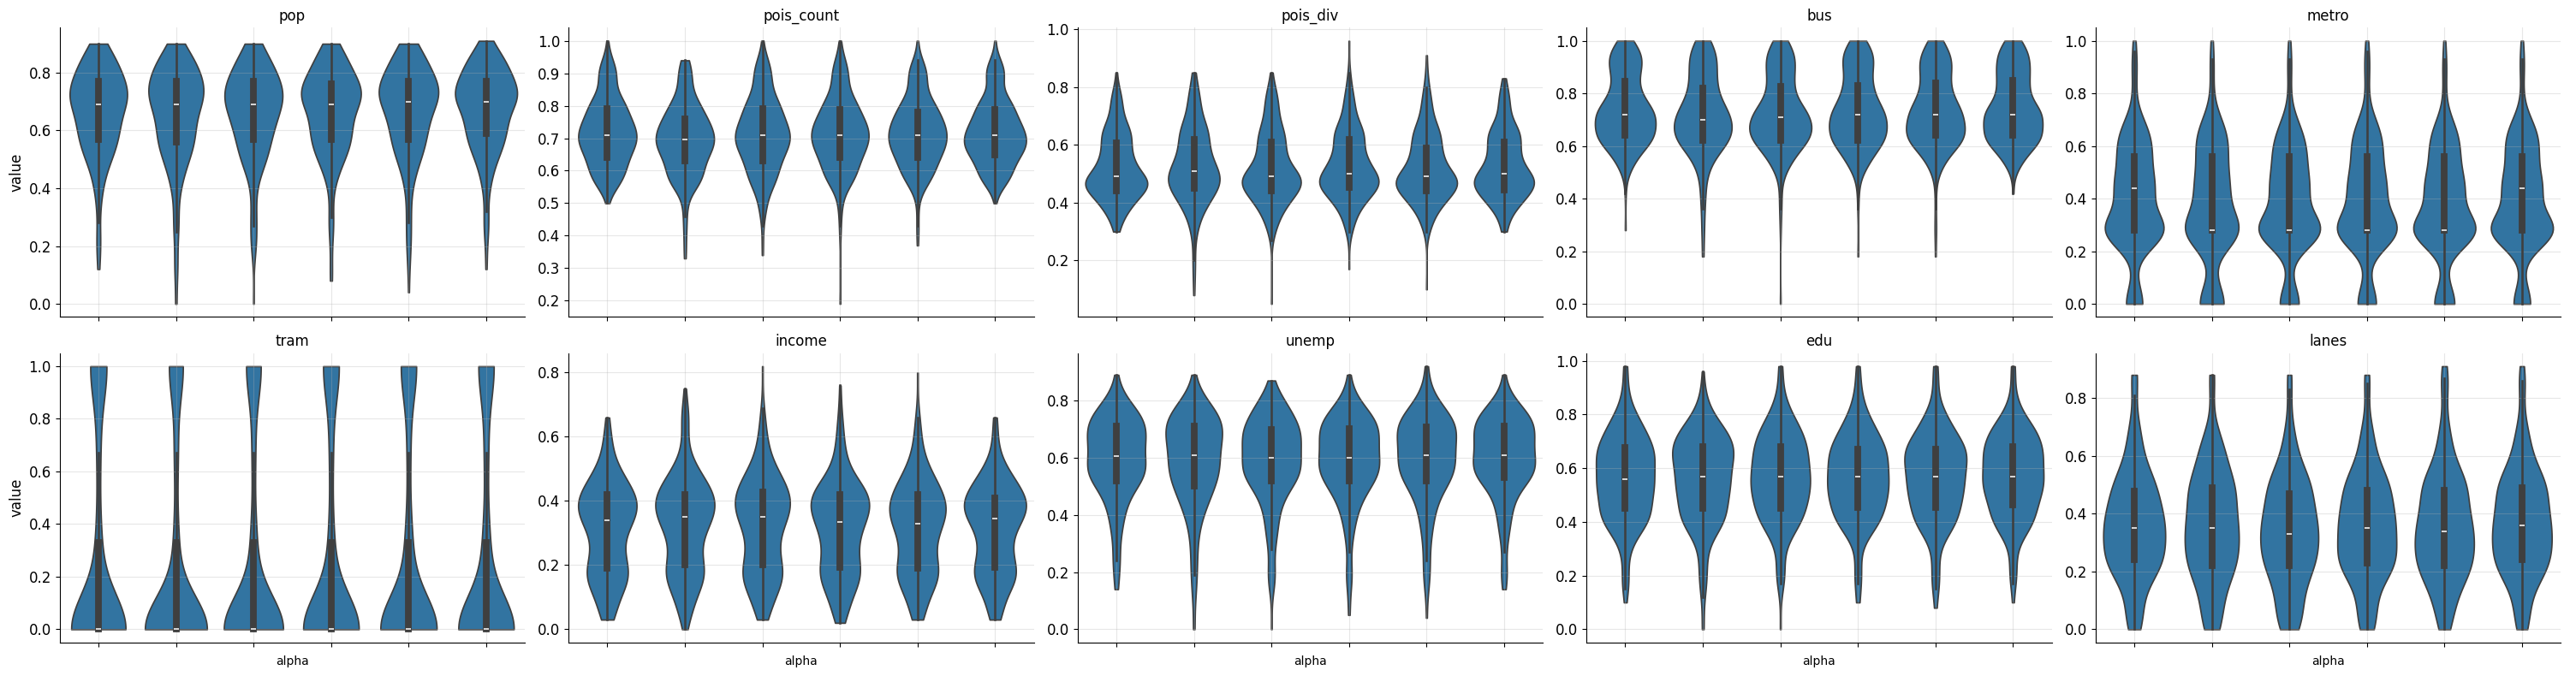

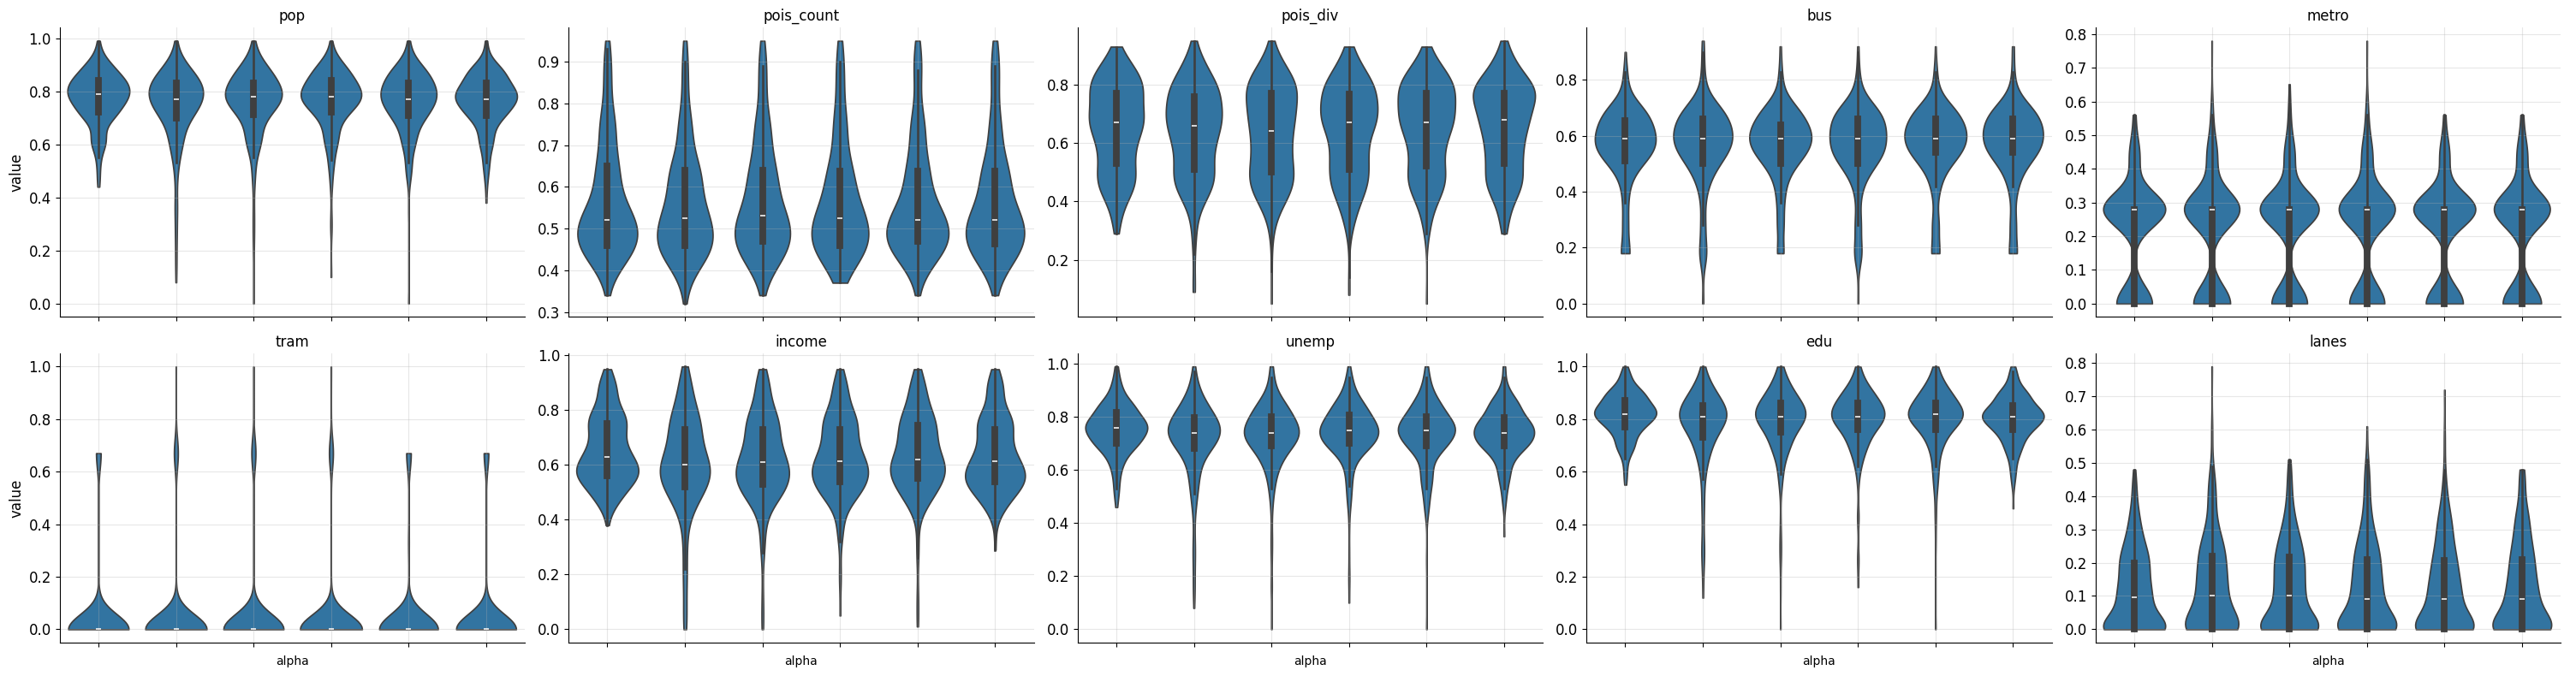

In [13]:
labelsize = 12
alpha_order = ['S1', '0.0', '0.25', '0.5', '0.75', '1.0']

for scenario_idx, scenario in enumerate(['s1', 's2', 's3']):
    alpha_order[0] = scenario.upper()
    plot_data = [{'variable': string_replace.get(var, var), 'alpha': alpha, 'value': values if not isinstance(values, np.ndarray) else values.tolist()} 
                 for var in alpha_scenarios[scenario][alpha_order[0]]['all_values'].keys()
                 for alpha in alpha_order
                 for values in [alpha_scenarios[scenario][alpha]['all_values'][var]]]
    
    plot_df = pd.DataFrame(plot_data).explode('value')
    plot_df['value'] = pd.to_numeric(plot_df['value'])
    
    g = sns.catplot(data=plot_df, x='alpha', y='value', col='variable', kind='violin',
                    height=4, aspect=1.5, col_wrap=5, sharey=False, inner='box', cut=0)
    
    for ax in g.axes.flat:
        variable = ax.get_title().split('=')[1].strip()
        ax.grid(alpha=0.3)
        ax.tick_params(axis='both', labelsize=labelsize)
        ax.set_title(variable, fontsize=labelsize)
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.yaxis.set_offset_position('left')
        ax.yaxis.offsetText.set_fontsize(labelsize)
        if ax.get_subplotspec().colspan.start == 0:
            ax.set_ylabel('value', fontsize=labelsize)
    
    plt.tight_layout()
    plt.show()

In [14]:
def plot_differences_from_baseline(
    ax, df_results, df_weights, vars, string_replace, alpha_order, labelsize=8
):
    # 1) α labels and numeric positions
    alpha_num = {alpha_order[0]:-0.2,
                 alpha_order[1]:0.0,
                 alpha_order[2]:0.25,
                 alpha_order[3]:0.5,
                 alpha_order[4]:0.75,
                 alpha_order[5]:1.0}
    
    x = [alpha_num[a] for a in alpha_order]

    # 2) Gather means
    means = {}
    for a in alpha_order:
        mask = (df_results['alpha'].astype(str)==a)
        sol  = df_results.loc[mask,'best_solution'].values[0]
        means[a] = df_weights.loc[sol, vars].mean()
    means_df = pd.DataFrame(means).T

    # 3) Differences from baseline
    diff_df = means_df.subtract(means_df.loc[alpha_order[0]], axis=1)

    # 4) Plot invisible bars to lock width
    width = 0.15
    for _ in diff_df.columns:
        ax.bar(x, 0, width=width, alpha=0)

    # 5) Plot the lines
    for col in sorted(diff_df.columns):
        label = string_replace.get(col, col)
        ax.plot(x, diff_df[col].values, marker=None, label=label)

    # 6) Ax formatting (keeping your y-limits & labels untouched)
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax.set_ylabel('$\Delta$ mean normalized values', fontsize=labelsize)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=labelsize, bbox_to_anchor=(1.05,1), loc='upper left')
    ax.tick_params(axis='both', labelsize=labelsize)

    # scientific notation at 10⁻²
    ax.locator_params(axis='y', nbins=4)
    fmt = ticker.ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((-2,-2))
    ax.yaxis.set_major_formatter(fmt)
    ax.yaxis.set_offset_position('left')
    ax.yaxis.offsetText.set_fontsize(labelsize*0.95)

    # 7) Restore your old xtick labels exactly
    labels = ["Baseline", 'α=0'] + [f"α={alpha}" for alpha in alpha_order[2:-1]] + ['α=1']
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=labelsize)

## 3.2. Graph metrics

In [15]:
import src.optimization.GA.graph_metric.graph_normalization as gn

# Compute bounds for stations
normalization_bounds = asp.compute_bounds_for_stations(
    G, distance_matrix, id_to_idx, idx_to_id, 
    [len(df_results['best_solution'].values[0])], 
    min_distance=300)

min_disp, max_disp, min_acc, max_acc = normalization_bounds[250]
disp_bounds = (min_disp, max_disp)
acc_bounds = (min_acc, max_acc)

In [16]:
def plot_acc_disp_composite(ax, alpha_order, inv_disps, acc_vals, composites, labelsize=8):
    """
    Plots Proximity, Accessibility, and Composite Score on three y-axes.
    X-axis is the true numeric α (with baseline at –0.2).
    Y-tick labels are shown with at most 2 decimals.
    Composite score is always shown from 0 to 1.
    """

    # Numeric positions for alpha
    x = [-0.2, 0.0, 0.25, 0.5, 0.75, 1.0]

    # Proximity (left y-axis)
    ax.plot(x, inv_disps, color='tab:blue', label='Proximity')
    ax.set_ylabel('Proximity', color='tab:blue', fontsize=labelsize)
    ax.tick_params(axis='y', labelcolor='tab:blue', labelsize=labelsize)

    # Set y-limits and ticks for Proximity
    def floor2(x): return np.floor(x * 100) / 100
    def ceil2(x): return np.ceil(x * 100) / 100
    data_min, data_max = np.min(inv_disps), np.max(inv_disps)
    pad = (data_max - data_min) * 0.08 if data_max > data_min else 0.01
    bottom, top = floor2(data_min - pad), ceil2(data_max + pad)
    ax.set_ylim(bottom, top)
    y_ticks = np.linspace(bottom, top, 5)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"{v:.2f}" for v in y_ticks], fontsize=labelsize)

    # Accessibility (right y-axis)
    ax2 = ax.twinx()
    ax2.plot(x, acc_vals, color='tab:red', label='Accessibility')
    ax2.set_ylabel('Accessibility', color='tab:red', fontsize=labelsize)
    ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=labelsize)
    ax2.spines['right'].set_position(('axes', 1.0))
    acc_min, acc_max = np.min(acc_vals), np.max(acc_vals)
    pad2 = (acc_max - acc_min) * 0.08 if acc_max > acc_min else 0.01
    acc_bottom, acc_top = floor2(acc_min - pad2), ceil2(acc_max + pad2)
    ax2.set_ylim(acc_bottom, acc_top)
    acc_ticks = np.linspace(acc_bottom, acc_top, 5)
    ax2.set_yticks(acc_ticks)
    ax2.set_yticklabels([f"{v:.2f}" for v in acc_ticks], fontsize=labelsize)

    # Composite (second right y-axis)
    ax3 = ax.twinx()
    ax3.bar(x, composites, width=0.15, alpha=0.3, color='gray', label='Composite')
    ax3.set_ylabel('Composite score', color='gray', fontsize=labelsize)
    ax3.tick_params(axis='y', labelcolor='gray', labelsize=labelsize)
    ax3.spines['right'].set_position(('axes', 1.2))
    ax3.set_ylim(0, 1)
    comp_ticks = np.linspace(0, 1, 5)
    ax3.set_yticks(comp_ticks)
    ax3.set_yticklabels([f"{v:.2f}" for v in comp_ticks], fontsize=labelsize)

    # X-axis labels
    xticks = x
    xtlabels = ["Baseline", 'α=0'] + [f'α={a}' for a in alpha_order[2:-1]] + ['α=1']
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtlabels, fontsize=labelsize)

    # Grid
    ax.grid(True, alpha=0.3)


In [17]:
def add_colorbar(fig, labelsize=8):
    # Create colorbar axis and 3 horizontal plot axes
    cax = fig.add_axes((0.92, 0.15, 0.02, 0.7))  # [left, bottom, width, height]

    # Create custom colormap with gray for zero values
    viridis_r = plt.get_cmap('viridis_r')
    colors = [(0.7, 0.7, 0.7, 1.0)]  # Start with gray
    colors.extend(viridis_r(np.linspace(0, 1, 255)))  # Add viridis_r colors
    custom_cmap = ListedColormap(colors)
    norm = Normalize(vmin=0, vmax=1)

    # Add colorbar
    sm = ScalarMappable(norm=norm, cmap=custom_cmap)
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label('Normalized node score $(U_i)$', fontsize=labelsize, labelpad=8)
    cax.tick_params(labelsize=labelsize)

α=S1 → inv_disp=0.668, acc_val=0.745, composite=N/A
α=0.0 → inv_disp=0.630, acc_val=0.918, composite=0.9175054399705553
α=0.25 → inv_disp=0.648, acc_val=0.898, composite=0.8351986175527689
α=0.5 → inv_disp=0.658, acc_val=0.890, composite=0.7738702708960442
α=0.75 → inv_disp=0.669, acc_val=0.849, composite=0.7137031393983714
α=1.0 → inv_disp=0.677, acc_val=0.755, composite=0.6766628012107457


/tmp/ipykernel_32052/806571069.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_xticklabels(xticklabels, fontsize=labelsize)
/tmp/ipykernel_32052/806571069.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_xticklabels(xticklabels, fontsize=labelsize)
/tmp/ipykernel_32052/1985676701.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


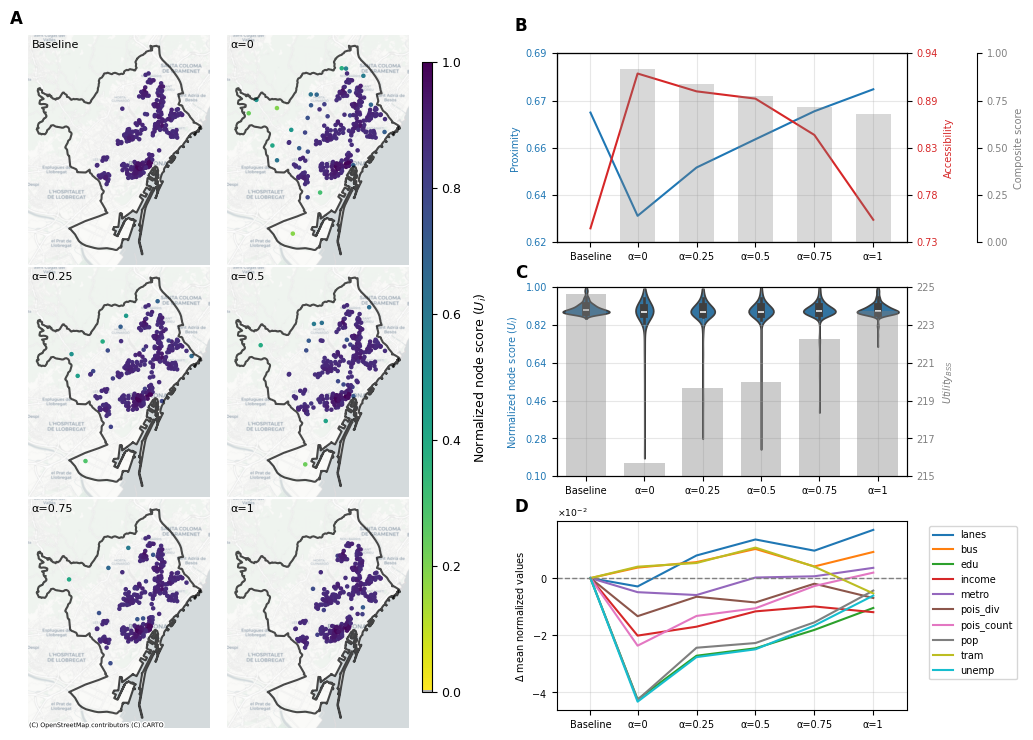

α=S2 → inv_disp=0.739, acc_val=0.747, composite=N/A
α=0.0 → inv_disp=0.702, acc_val=0.906, composite=0.9059332736100227
α=0.25 → inv_disp=0.710, acc_val=0.894, composite=0.8480633419621831
α=0.5 → inv_disp=0.722, acc_val=0.863, composite=0.7925339360722026
α=0.75 → inv_disp=0.737, acc_val=0.842, composite=0.7628833163334316
α=1.0 → inv_disp=0.744, acc_val=0.704, composite=0.7439614660064023


/tmp/ipykernel_32052/806571069.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_xticklabels(xticklabels, fontsize=labelsize)
/tmp/ipykernel_32052/806571069.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_xticklabels(xticklabels, fontsize=labelsize)
/tmp/ipykernel_32052/1985676701.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


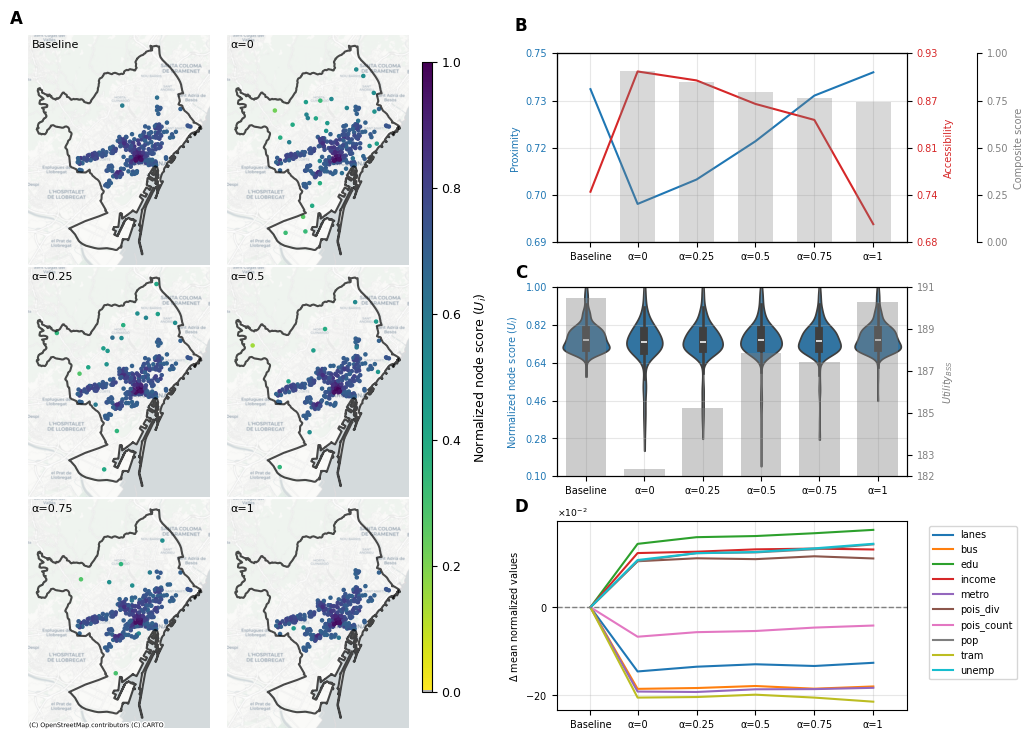

α=S3 → inv_disp=0.538, acc_val=0.704, composite=N/A
α=0.0 → inv_disp=0.519, acc_val=0.909, composite=0.9088546593126176
α=0.25 → inv_disp=0.525, acc_val=0.888, composite=0.7970287254983139
α=0.5 → inv_disp=0.541, acc_val=0.864, composite=0.7023360517698407
α=0.75 → inv_disp=0.538, acc_val=0.864, composite=0.6198096332439628
α=1.0 → inv_disp=0.554, acc_val=0.722, composite=0.5537680424383029


/tmp/ipykernel_32052/806571069.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_xticklabels(xticklabels, fontsize=labelsize)
/tmp/ipykernel_32052/806571069.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_xticklabels(xticklabels, fontsize=labelsize)
/tmp/ipykernel_32052/1985676701.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


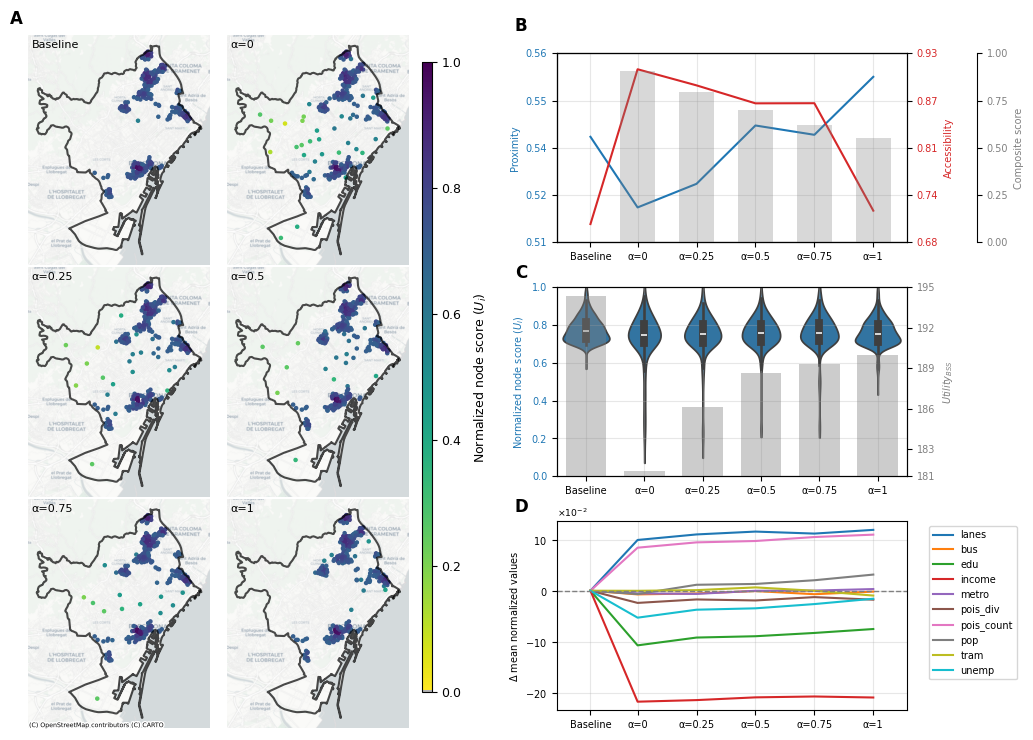

In [18]:
title_size = 12

# Define the order of α including the baseline first
alpha_order = ['S1', '0.0', '0.25', '0.5', '0.75', '1.0']

for scenario_idx, scenario in enumerate(['s1', 's2', 's3']):

    # Replace first element of alpha_order with capitalized scenario
    alpha_order[0] = scenario.upper()
    
    # Create main axes and subplots
    fig = plt.figure(figsize=(5, 9))
    gs = fig.add_gridspec(3, 2, width_ratios=[1,1], wspace=0.05, hspace=0.01)
    axs = []
    for row in range(3):
        for col in range(2):
            axs.append(fig.add_subplot(gs[row,col]))
    axs = np.array(axs)
    
    # Lists to store metrics for line plot
    alphas_plot, inv_disps, acc_vals, composites = [], [], [], []

    # Iterate over alphas and plot maps
    for i, alpha in enumerate(alpha_order):
        # Get stations for this alpha
        if alpha not in ['S1', 'S2', 'S3']:
            alpha = float(alpha)

        stations = df_results[
            (df_results['alpha'] == alpha) & 
            (df_results['weights'] == weights_dict[scenario])
        ]['best_solution'].values[0]
        
        # Filter weights dataframe to only include selected stations
        df_weights_filtered = df_weights[df_weights.index.isin(stations)]

        # Plot map with filtered stations
        hv.plot_nodes_on_map(df_weights_filtered, f'{scenario}', axs[i], city_boundary, 
                            ctx_background=True, show_colorbar=False, show_norm_raw_vals=False, node_size=5,
                            attribution=(i==len(alpha_order)-2), attribution_size=4.5) # Only show attribution on first plot

        # Add alpha label in top left
        label_alpha = alpha
        if alpha not in ['S1', 'S2', 'S3']:
            # Handle both float and string representations of 0.0 and 1.0
            if (isinstance(alpha, float) and (alpha == 0.0 or alpha == 1.0)) or \
               (isinstance(alpha, str) and (alpha == '0.0' or alpha == '1.0')):
                label_alpha = int(float(alpha))
            elif isinstance(alpha, float):
                label_alpha = round(alpha, 2)

            axs[i].text(0.02, 0.98, f'α={label_alpha}', transform=axs[i].transAxes, fontsize=8, verticalalignment='top')
        else:
            axs[i].text(0.02, 0.98, f'Baseline', transform=axs[i].transAxes, fontsize=8, verticalalignment='top')

        # Add letter A to identify maps
        if i == 0:
            axs[i].text(-0.1, 1.05, f'A', transform=axs[i].transAxes, fontsize=title_size, fontweight='bold')
            
        # Convert node IDs to indices for evaluation
        nodes_idx_list = [id_to_idx.get(node, -1) for node in stations if node in id_to_idx]
        
        # Skip nodes that aren't in the mapping
        valid_nodes_idx_list = [idx for idx in nodes_idx_list if idx != -1]
        
        # Calculate metrics
        if alpha in ['S1', 'S2', 'S3']:
            # For no metrics case, calculate individual metrics without composite
            inv_disp, acc_val, _ = gn.evaluate_normalize_and_invert_stations_set(
                valid_nodes_idx_list, distance_matrix, 0.0, disp_bounds, acc_bounds
            )
            composite = None
            alphas_plot.append(-0.2)  # Plot "No graph metrics" slightly to the left of 0
        else:
            # For alpha cases, calculate all metrics including composite
            inv_disp, acc_val, composite = gn.evaluate_normalize_and_invert_stations_set(
                valid_nodes_idx_list, distance_matrix, alpha, disp_bounds, acc_bounds
            )
            alphas_plot.append(alpha)

        inv_disps.append(inv_disp)
        acc_vals.append(acc_val)
        composites.append(composite if composite is not None else 0)

        print(f"α={alpha} → inv_disp={inv_disp:.3f}, acc_val={acc_val:.3f}, composite={composite if composite is not None else 'N/A'}")


    add_colorbar(fig, labelsize=9)

    # [left, bottom, width, height]
    line_ax1 = fig.add_axes((1.19, 0.65, 0.7, 0.21))  # Top plot
    line_ax2 = fig.add_axes((1.19, 0.39, 0.7, 0.21))  # Middle plot 
    line_ax3 = fig.add_axes((1.19, 0.13, 0.7, 0.21))  # Bottom plot

    # Add letters B, C, D to identify plots
    line_ax1.text(-0.12, 1.12, 'B', transform=line_ax1.transAxes, fontsize=title_size, fontweight='bold')
    line_ax2.text(-0.12, 1.05, 'C', transform=line_ax2.transAxes, fontsize=title_size, fontweight='bold')
    line_ax3.text(-0.12, 1.05, 'D', transform=line_ax3.transAxes, fontsize=title_size, fontweight='bold')

    # Plots
    labelsize = 7
    plot_acc_disp_composite(line_ax1, alphas_plot, inv_disps, acc_vals, composites, labelsize=labelsize)
    plot_node_scores_plot(line_ax2, alpha_order, alpha_scenarios, scenario, labelsize=labelsize)
    plot_differences_from_baseline(line_ax3, df_results, df_weights, vars, string_replace, alpha_order, labelsize=labelsize)

    # Save figure with tight layout and high dpi
    plt.tight_layout()
    fig.savefig(f'{ROOT}/{VISUALIZATIONS}/scenarios/alpha_screening/alpha_screening_{scenario}.png', 
                dpi=300, bbox_inches='tight', pad_inches=0.1)

    plt.show()